In [1]:
import numpy as np
import paddle
import paddle.io as io
from nndl_4_2.dataset import load_data
# import nndl_4_2.dataset as load_data

class IrisDataset(io.Dataset):
    def __init__(self, mode='train', num_train=120, num_dev=15):
        super(IrisDataset, self).__init__()
        # 调用第三章中的数据读取函数，其中不需要将标签转成one-hot类型
        X, y = load_data(shuffle=True)
        if mode == 'train':
            self.X, self.y = X[:num_train], y[:num_train]
        elif mode == 'dev':
            self.X, self.y = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
        else:
            self.X, self.y = X[num_train + num_dev:], y[num_train + num_dev:]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [2]:
paddle.seed(12)
train_dataset = IrisDataset(mode='train')
dev_dataset = IrisDataset(mode='dev')
test_dataset = IrisDataset(mode='test')

# 打印训练集长度
print("length of train set: ",len(train_dataset))

length of train set:  120


In [3]:
# 用DataLoader进行封装

# 批量大小
batch_size = 16

# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)

In [4]:
# 模型构建

from paddle import nn

class Model_MLP_L2_V3(nn.Layer):
    def __init__(self, input_size, output_size, hidden_size):
        super(Model_MLP_L2_V3, self).__init__()

        # 构建第一个全连接层
        self.fc1 = nn.Linear(input_size,hidden_size,
                             weight_attr=paddle.ParamAttr(initializer=nn.initializer.Normal(mean=0.0, std=0.01)),
                             bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0)))
        
        # 构建第二个全连接层
        self.fc2 = nn.Linear(hidden_size, output_size,
                             weight_attr=paddle.ParamAttr(initializer=nn.initializer.Normal(mean=0.0, std=0.01)),
                             bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0)))
        
        # 定义网络使用激活函数
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.act(outputs)
        outputs = self.fc2(outputs)
        return outputs
    
fnn_model = Model_MLP_L2_V3(input_size=4, output_size=3, hidden_size=6)

In [5]:
# 完善Runner类
from paddle.metric import Metric

class Accuracy(Metric):
    def __init__(self, is_logist=True):
        """
        输入：
           - is_logist: outputs是logist还是激活后的值
        """

        # 用于统计正确的样本个数
        self.num_correct = 0
        # 用于统计正确样本个数
        self.num_count = 0

        self.is_logist = is_logist

    def update(self, outputs, labels):
        """
        输入：
           - outputs: 预测值, shape=[N,class_num]
           - labels: 标签值, shape=[N,1]
        """

        # 判断是二分类任务还是多分类任务，shape[1]=1时为二分类任务，shape[1]>1时为多分类任务
        if outputs.shape[1] == 1: #二分类
            outputs = paddle.squeeze(outputs, axis=-1)
            if self.is_logist:
                # logist判断是否大于0
                preds = paddle.cast((outputs>=0), dtype='float32')
            else:
                # 如果不是logist，判断每个概率值是否大于0.5，当大于0.5时，类别为1，否则类别为0
                preds = paddle.cast((outputs>=0.5), dtype='float32')
        else:
            # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
            preds = paddle.argmax(outputs, axis=1, dtype='int64')

        # 获取本批数据中预测正确的样本个数
        labels = paddle.squeeze(labels, axis=-1)
        batch_correct = paddle.sum(paddle.cast(preds==labels, dtype="float32")).numpy()[0]
        batch_count= len(labels)

        # 更新num_correct 和num_count
        self.num_correct +=batch_correct
        self.num_count += batch_count

    def accumulate(self):
        # 使用累计的数据，计算总的指标
        if self.num_count == 0:
            return 0
        return self.num_correct/self.num_count
    
    def reset(self):
        # 重置正确的数目和总数
        self.num_correct = 0
        self.num_count = 0

    def name(self):
        return "Accuracy"



In [10]:
# RunnerV3类

import paddle.nn.functional as F

class RunnerV3(object):
    def __init__(self, model, optimizer, loss_fn, metric, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric # 只用于计算评价指标

        # 记录训练过程中的评价指标变化情况
        self.dev_scores = []

        # 记录训练过程中的损失函数变化情况
        self.train_epoch_losses = [] # 一个epoch记录一次loss
        self.train_step_losses = [] # 一个step记录一次loss
        self.dev_losses = []

        # 记录全局最优指标
        self.best_score = 0

    def train(self, train_loader, dev_loader=None, **kwargs):
        # 将模型切换为训练模式
        self.model.train()

        # 传入训练轮数，如果没有传入值则默认为0
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入log打印频率，如果没有传入值则默认为100
        log_steps = kwargs.get("log_steps", 100)
        # 评价频率
        eval_steps =kwargs.get("eval_steps", 0)

        # 传入模型保存路径，如果没有传入值则默认为"best_model_RunnerV3.pdparams"
        save_path = kwargs.get("save_path", "best_model_RunnerV3.pdparams")

        custom_print_log = kwargs.get("custom_print_log", None)

        # 训练总的步数
        num_training_steps = num_epochs *len(train_loader)

        if eval_steps:
            if self.metric is None:
                raise RuntimeError("Error: Metric can not be None!")
            if dev_loader is None:
                raise RuntimeError("Error dev_loader can not be None!")
            
        # 运行的step数目
        global_step = 0

        # 进行num_epochs轮训练
        for epoch in range(num_epochs):
            # 用于统计训练集的损失
            total_loss = 0
            for step,data in enumerate(train_loader):
                X, y =data
                # 获取模型预测
                logits = self.model(X)
                loss = self.loss_fn(logits, y) # 默认求mean
                total_loss +=loss

                # 训练过程中，每个step的loss进行保存
                self.train_step_losses.append((global_step, loss.item()))

                if log_steps and global_step%log_steps==0:
                    print(f"[Train] epoch :{epoch}/{num_epochs}, step:{global_step}/{num_training_steps}, loss:{loss.item():.5f}")

                # 梯度反向传播，计算每个参数的梯度值
                loss.backward()

                if custom_print_log:
                    custom_print_log(self)

                # 小批量梯度下降进行参数更新
                self.optimizer.step()
                # 梯度归零
                self.optimizer.clear_grad()

                # 判断是否需要评价
                if eval_steps>0 and global_step>0 and (global_step%eval_steps==0 or global_step==(num_training_steps-1)):
                    dev_score, dev_loss = self.evaluate(dev_loader, global_step=global_step)
                    print(f"[Evaluate] dev score: {dev_score:.5f}, dev loss:{dev_loss:.5f}")

                    # 将模型切换为训练模式
                    self.model.train()

                    # 如果当前指标为最优指标，保存该模型
                    if dev_score > self.best_score:
                        self.save_model(save_path)
                        print(f"[Evaluate] best accuracy performence has been updated: {self.best_score:.5f} --> {dev_score:.5f}")
                        self.best_score = dev_score

                global_step += 1

            # 当前epoch 训练loss累计值
            trn_loss = (total_loss / len(train_loader)).item()

            # 当epoch粒度的训练loss保存
            self.train_epoch_losses.append(trn_loss)

        print("[Train] Tranining done!")

    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def evaluate(self, dev_loader, **kwargs):            
        assert self.metric is not None

        # 将模式设置为评估模式
        self.model.eval()

        global_step = kwargs.get("global_step", -1)

        # 用于统计训练集损失
        total_loss = 0

        # 重置评价
        self.metric.reset()

        # 遍历验证集每个批次
        for batch_id, data in enumerate(dev_loader):
            X, y =data

            # 计算模型输出
            logits = self.model(X)
            loss = self.loss_fn(logits, y).item()
            # 累计损失
            total_loss += loss

            # 累计评价
            self.metric.update(logits, y)

        dev_loss = (total_loss/len(dev_loader))
        dev_score = self.metric.accumulate()

        # 记录验证集loss
        if global_step!=-1:
            self.dev_losses.append((global_step,dev_loss))
            self.dev_scores.append(dev_score)

        return dev_score, dev_loss
    
    # 模型评估阶段，使用'paddle.no_grad()'控制不计算和存储梯度
    @paddle.no_grad()
    def predict(self, x, **kwargs):
        # 将模式设置为评估模式
        self.model.eval()
        # 运行模型前向计算，得到预测值
        logits = self.model(x)
        return logits
    
    def save_model(self, save_path):
        paddle.save(self.model.state_dict(), save_path)

    def load_model(self, model_path):
        model_state_dict = paddle.load(model_path)
        self.model.set_state_dict(model_state_dict)

In [11]:
import paddle.optimizer as opt

lr = 0.2

# 定义网络
model = fnn_model

# 定义优化器
optimizer = opt.SGD(learning_rate=lr, parameters=model.parameters())

# 定义损失函数， softmax + 交叉熵
loss_fn = F.cross_entropy

# 定义评价指标
metric = Accuracy(is_logist=True)

runner = RunnerV3(model, optimizer, loss_fn, metric)

In [12]:
# 启动训练
log_steps = 100
eval_steps = 50
runner.train(train_loader, dev_loader, num_epochs=150, log_steps=log_steps, 
             eval_steps =eval_steps, save_path="best_model_RunnerV3.pdparams")

[Train] epoch :0/150, step:0/1200, loss:1.09948
[Evaluate] dev score: 0.26667, dev loss:1.15609
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.26667
[Train] epoch :12/150, step:100/1200, loss:1.13139
[Evaluate] dev score: 0.26667, dev loss:1.10575
[Evaluate] dev score: 0.40000, dev loss:1.10268
[Evaluate] best accuracy performence has been updated: 0.26667 --> 0.40000
[Train] epoch :25/150, step:200/1200, loss:1.09113
[Evaluate] dev score: 0.40000, dev loss:1.09122
[Evaluate] dev score: 0.26667, dev loss:1.13334
[Train] epoch :37/150, step:300/1200, loss:1.08642
[Evaluate] dev score: 0.40000, dev loss:1.08082
[Evaluate] dev score: 0.66667, dev loss:1.05484
[Evaluate] best accuracy performence has been updated: 0.40000 --> 0.66667
[Train] epoch :50/150, step:400/1200, loss:0.93283
[Evaluate] dev score: 0.53333, dev loss:0.91869
[Evaluate] dev score: 0.86667, dev loss:0.75771
[Evaluate] best accuracy performence has been updated: 0.66667 --> 0.86667
[Train] epoch :6

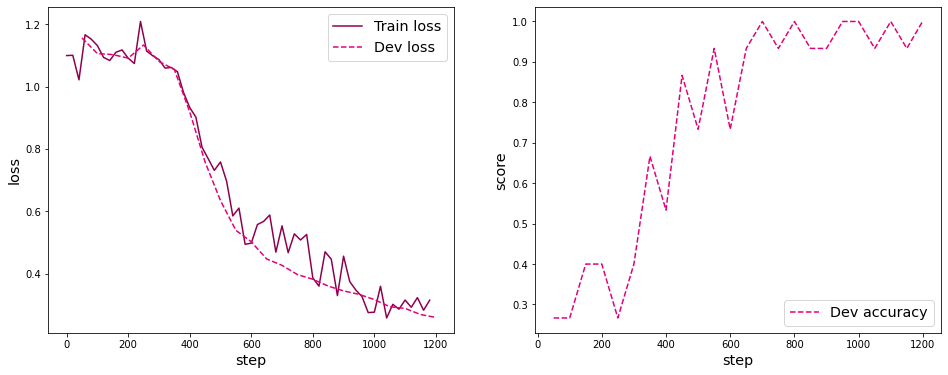

In [14]:
import matplotlib.pyplot as plt

# 绘制训练集和验证集的损失变化以及验证集上的准确率变化曲线

def plot_training_loss_acc(runner, fig_name, fig_size=(16,6), sample_step=20, 
                           loss_legend_loc = "upper right", acc_legend_loc = "lower right",
                           train_color = "#8E004D", dev_color = "#E20079",
                           fontsize = 'x-large', train_linestyle = '-', dev_linestyle = '--'):
    plt.figure(figsize=fig_size)
    plt.subplot(1,2,1)
    train_items = runner.train_step_losses[::sample_step]
    train_steps = [x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]
    
    plt.plot(train_steps, train_losses, color = train_color, linestyle = train_linestyle, label = "Train loss")
    if len(runner.dev_losses)>0:
        dev_steps = [x[0] for x in runner.dev_losses]
        dev_losses = [x[1] for x in runner.dev_losses]
        plt.plot(dev_steps, dev_losses, color = dev_color, linestyle = dev_linestyle, label = "Dev loss")

    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize = fontsize)
    plt.xlabel("step", fontsize = fontsize)
    plt.legend(loc = loss_legend_loc, fontsize = fontsize)

    # 绘制评价准确率变化曲线
    if len(runner.dev_scores)>0:
        plt.subplot(1,2,2)
        plt.plot(dev_steps, runner.dev_scores, color = dev_color, linestyle= dev_linestyle, label = "Dev accuracy")

        # 绘制坐标轴和图例
        plt.ylabel("score", fontsize = fontsize)
        plt.xlabel("step", fontsize = fontsize)
        plt.legend(loc = acc_legend_loc, fontsize =fontsize)
    
    plt.savefig(fig_name)
    plt.show()

plot_training_loss_acc(runner, "fw-loss.pdf")

In [15]:
# 加载最优模型
runner.load_model("best_model_RunnerV3.pdparams")
# 模型评价
score, loss = runner.evaluate(test_loader)
print(f"[Test] accuracy/loss: {score:.4f}/{loss:.4f}")

[Test] accuracy/loss: 0.9333/0.5073


In [16]:
# 模型预测
X, label = next(test_loader())
logits = runner.predict(X)

pred_class = paddle.argmax(logits[0]).numpy()

label = label[0][0].numpy()

# 输出真实类别与预测类别
print(f"The true category is {label} and the predicted category is {pred_class}")

The true category is [0] and the predicted category is [0]
